utils.py

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import math

In [2]:
# Problem Set 4: Problem 4
def loadAndCleanData(file):
    dataset = pd.read_csv(file,encoding='utf-8')
    dataset.fillna(value=0,inplace=True)
    # this next line was taken from https://stackoverflow.com/questions/22649693/drop-rows-with-all-zeros-in-pandas-data-frame
    dataset = dataset.loc[(dataset!=0).any(axis=1)] # this lets me drop rows where all values are 0
    return dataset

In [3]:
def computeProbability(feature, bin, data):
    count = 0.0
    for i,datapoint in data.iterrows():
        if datapoint[feature] >= bin[0] and datapoint[feature] < bin[1]:
            count += 1
    return count / len(data)

In [4]:
def computeConfidenceInterval(data):
    npArray = 1.0 * np.array(data)
    stdErr = scipy.stats.sem(npArray)
    n = len(data)
    return stdErr * scipy.stats.t.ppf((1+.95)/2.0,n-1)

In [5]:
def getEffectSize(d1,d2):
    m1 = d1.mean()
    m2 = d2.mean()
    s1 = d1.std()
    s2 = d1.std()
    return (m1 - m2) / math.sqrt((math.pow(s1,3) + math.pow(s2, 3)) / 2.0)

In [6]:
# Problem Set 4: Problem 20.1
def runTTest(d1,d2):
    return scipy.stats.ttest_ind(d1,d2)

In [7]:
def runANOVA(dataframe,vars):
    model = ols(vars, data=dataframe).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    return aov_table

In [8]:
# Problem Set 4: Problem 19.1
def getConfidenceIntervals(datacolumn):
    npArray = 1.0 * np.array(datacolumn)
    stdErr = scipy.stats.sem(npArray)
    n = len(datacolumn)
    return stdErr * scipy.stats.t.ppf((1+.95)/2.0,n-1)

poll.py

In [9]:
class Poll:
    def __init__(self, name, df):
        self.outlet = name
        self.data = df.loc[df["Poll"]==name]

    def getMostRecentPoll(self):
        return self.data.iloc[0]

    def countPoll(self):
        return len(self.data)

    def changeInPoll(self, candidate):
        candidateData = self.data[candidate]
        return candidateData.iloc[0] - candidateData.iloc[len(candidateData)-1]

    def avgInPoll(self, candidate):
        return self.data[candidate].mean()

    def medianInPoll(self, candidate):
        return self.data[candidate].median()

    def correlatedPoll(self, candidate1, candidate2):
        if (self.countPoll() == 1):
            print("not enough data")
            return 0
        else:
            return self.data[candidate1].corr(self.data[candidate2])

    def pollUncertainty(self, candidate):
        return self.data[candidate].std()

    def pollStdDev(self,candidate):
        upperQuantile = self.data[candidate].quantile(.75)
        lowerQuantile = self.data[candidate].quantile(.25)
        return upperQuantile - lowerQuantile

    def pollErrorMargin(self,candidate):
        n = self.countPoll()
        sigma = self.data[candidate].std()
        z = 1.96
        return z * sigma / math.sqrt(n)

    def pollConfidence(self,candidate):
        npArray = 1.0 * np.array(self.data[candidate])
        stdErr = scipy.stats.sem(npArray)
        n = self.countPoll()
        return stdErr * scipy.stats.t.ppf((1+.95)/2.0,n-1)

pollingData.py

In [10]:
import matplotlib.pyplot as plt

In [11]:
# Problem Set 4: Problem 5
def normalizeData(dataset):
    newcolumn = []
    for i, row in dataset.iterrows():
        row.drop(labels=['Poll','Date','Sample','Spread'],inplace=True)
        value = 100 - row.sum()
        newcolumn.append(value)
    dataset['Undecided'] = newcolumn

In [12]:
# Problem Set 4: Problem 7
def plotCandidate(candidate,dataset):
    plt.scatter(dataset["Poll"],dataset[candidate])
    plt.title(candidate)
    plt.show()

In [13]:
# Problem Set 4: Problem 8
def statsPerCandidate(candidate,dataset):
    return dataset[candidate].mean()

In [14]:
# Problem Set 5: Problem 10
def cleanSample(dataset):
    sampleType = []
    sampleSize = []
    for i, row in dataset.iterrows():
        if 'RV' in row["Sample"]:
            sampleType.append('RV')
            sampleSize.append(row["Sample"].replace(' RV',''))
        elif 'LV' in row["Sample"]:
            sampleType.append('RV')
            sampleSize.append(row["Sample"].replace(' LV',''))
    for size in range(len(sampleSize)):
        if 'RV' not in sampleSize[size] and 'LV' not in sampleSize[size]:
            sampleSize[size] = int(sampleSize[size])
        else:
            sampleSize[size] = 0
    dataset["Sample Type"] = sampleType
    dataset["Sample Size"] = sampleSize

In [15]:
#df[df['Poll'] == "NBC News/Wall St. JrnlNBC/WSJ"]

In [16]:
#df[df['Poll'] == "NBC News/Wall St. JrnlNBC/WSJ"]["Sample Size"]

In [17]:
#sum(df[df['Poll'] == "NBC News/Wall St. JrnlNBC/WSJ"]["Sample Size"])

In [18]:
# Problem Set 4: Problem 12.1
def computePollWeight(dataset,poll):
    return sum(dataset[dataset['Poll'] == poll]["Sample Size"]) / sum(dataset["Sample Size"])

In [19]:
#computePollWeight(df,"NBC News/Wall St. JrnlNBC/WSJ")

In [20]:
# Problem Set 4: Problem 17
def superTuesday(dataset,candidates):
    BidenST = []
    SandersST = []
    
    for i, row in dataset.iterrows():
        
        BidenCount = row["Biden"]
        SandersCount = row["Sanders"]
        
        for candidate in candidates:
            
            if candidate != "Biden" and candidate != "Sanders":
                BidenCorr = computeCorrelation("Biden",candidate,dataset)
                SandersCorr = computeCorrelation("Sanders",candidate,dataset)
                
                if abs(BidenCorr) > abs(SandersCorr):
                    BidenCount += row[candidate]
                else:
                    SandersCount += row[candidate]
        
        BidenST.append(BidenCount)
        SandersST.append(SandersCount)
    
    dataset["BidenST"] = BidenST
    dataset["SandersST"] = SandersST

main.py

In [21]:
df = loadAndCleanData("2020_democratic_presidential_nomination-6730.csv")

pollNames = pd.unique(df["Poll"])

polls = []

for name in pollNames:
    poll = Poll(name, df)
    polls.append(poll)

'''
    print(poll.outlet)
    print(poll.getMostRecentPoll())
    print(poll.countPoll)
    print(poll.changeInPoll("Sanders"))
    print(poll.avgInPoll("Sanders"))
'''

'\n    print(poll.outlet)\n    print(poll.getMostRecentPoll())\n    print(poll.countPoll)\n    print(poll.changeInPoll("Sanders"))\n    print(poll.avgInPoll("Sanders"))\n'

In [22]:
# Problem Set 4: Problem 6
normalizeData(df)
df.head() # print(df)

,Poll,Date,Sample,Biden,Sanders,Spread,Undecided
1,ABC News/Wash PostABC/WP,3/22 - 3/25,388 RV,55.0,39.0,Biden +16,6.0
3,Economist/YouGovYouGov,3/22 - 3/24,547 LV,57.0,39.0,Biden +18,4.0
5,Reuters/IpsosReuters,3/18 - 3/24,1981 RV,53.0,34.0,Biden +19,13.0
7,Morning ConsultM. Consult,3/16 - 3/22,16180 LV,60.0,36.0,Biden +24,4.0
9,EmersonEmerson,3/18 - 3/19,519 RV,54.0,42.0,Biden +12,4.0


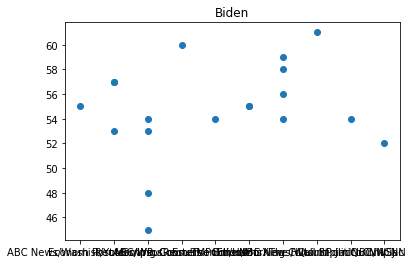

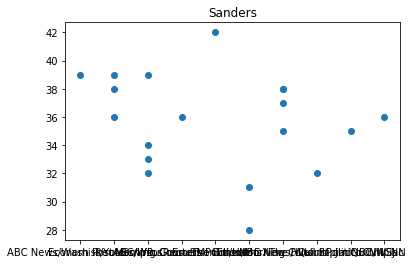

In [23]:
# Problem Set 4: Problem 7
for candidate in df.columns:
    if candidate not in ['Poll','Date','Sample','Spread','Undecided']:
        plotCandidate(candidate,df)

In [24]:
# Problem Set 4: Problem 9
myCans = []

for candidate in df.columns:
    if candidate not in ['Poll','Date','Sample','Spread','Undecided']:
        myCans.append(candidate)
        print(candidate,statsPerCandidate(candidate,df))

Biden 54.73684210526316
Sanders 35.68421052631579


In [25]:
# Problem Set 4: Problem 11
cleanSample(df)

In [26]:
df.head()

,Poll,Date,Sample,Biden,Sanders,Spread,Undecided,Sample Type,Sample Size
1,ABC News/Wash PostABC/WP,3/22 - 3/25,388 RV,55.0,39.0,Biden +16,6.0,RV,388
3,Economist/YouGovYouGov,3/22 - 3/24,547 LV,57.0,39.0,Biden +18,4.0,RV,547
5,Reuters/IpsosReuters,3/18 - 3/24,1981 RV,53.0,34.0,Biden +19,13.0,RV,1981
7,Morning ConsultM. Consult,3/16 - 3/22,16180 LV,60.0,36.0,Biden +24,4.0,RV,16180
9,EmersonEmerson,3/18 - 3/19,519 RV,54.0,42.0,Biden +12,4.0,RV,519


In [27]:
# Problem Set 4: Problem 12.2
print(computePollWeight(df,"Morning ConsultM. Consult"))
print(computePollWeight(df,"CNNCNN"))
print(computePollWeight(df,"ABC News/Wash PostABC/WP"))

0.3450776318034465
0.011516806005801059
0.008275038389353352


In [28]:
for poll in df["Poll"].unique():
    print(poll)

ABC News/Wash PostABC/WP
Economist/YouGovYouGov
Reuters/IpsosReuters
Morning ConsultM. Consult
EmersonEmerson
The Hill/HarrisXThe Hill
Politico/Morning ConsultPolitico
NBC News/Wall St. JrnlNBC/WSJ
QuinnipiacQuinnipiac
CNNCNN


In [29]:
computePollWeight(df,"ABC News/Wash PostABC/WP")

0.008275038389353352

In [30]:
sum(df[df["Poll"] == "ABC News/Wash PostABC/WP"]["Sanders"])

39.0

In [31]:
sum(df[df["Poll"] == "ABC News/Wash PostABC/WP"]["Sanders"]) * computePollWeight(df,"ABC News/Wash PostABC/WP")

0.32272649718478075

In [32]:
# Problem Set 4: Problem 13
def weightedStatsPerCandidate(candidate,dataset):
    weightedAverages = []
    for poll in df["Poll"].unique():
        val = sum(df[df["Poll"] == poll][candidate]) * computePollWeight(dataset,poll)
        weightedAverages.append(val)
    return sum(weightedAverages) / len(weightedAverages)

In [33]:
weightedStatsPerCandidate("Sanders",df)

9.906125234601605

In [34]:
weightedStatsPerCandidate("Biden",df)

15.301388414946256

In [35]:
# Problem Set 4: Problem 15
def computeCorrelation(candidate1,candidate2,dataset):
    return dataset[candidate1].corr(dataset[candidate2])

In [36]:
computeCorrelation("Sanders","Biden",df)

-0.015205292657614304

In [37]:
# Problem Set 4: Problem 16
repeatList = []

for candidate1 in myCans:
    for candidate2 in myCans:
        if candidate1 != candidate2:
            if [candidate1,candidate2] not in repeatList and [candidate2,candidate1] not in repeatList:
                print(candidate1,"vs",candidate2,":",computeCorrelation(candidate1,candidate2,df))
                repeatList.append([candidate1,candidate2])

Biden vs Sanders : -0.015205292657614304


In [38]:
print("Biden and Klobuchar are the most correlated.")
print("Sanders and Steyer are the least correlated.")

Biden and Klobuchar are the most correlated.
Sanders and Steyer are the least correlated.


In [39]:
# Problem Set 4: Problem 18
superTuesday(df,myCans)

In [40]:
df

,Poll,Date,Sample,Biden,Sanders,Spread,Undecided,Sample Type,Sample Size,BidenST,SandersST
1,ABC News/Wash PostABC/WP,3/22 - 3/25,388 RV,55.0,39.0,Biden +16,6.0,RV,388,55.0,39.0
3,Economist/YouGovYouGov,3/22 - 3/24,547 LV,57.0,39.0,Biden +18,4.0,RV,547,57.0,39.0
5,Reuters/IpsosReuters,3/18 - 3/24,1981 RV,53.0,34.0,Biden +19,13.0,RV,1981,53.0,34.0
7,Morning ConsultM. Consult,3/16 - 3/22,16180 LV,60.0,36.0,Biden +24,4.0,RV,16180,60.0,36.0
9,EmersonEmerson,3/18 - 3/19,519 RV,54.0,42.0,Biden +12,4.0,RV,519,54.0,42.0
11,Economist/YouGovYouGov,3/15 - 3/17,551 LV,57.0,36.0,Biden +21,7.0,RV,551,57.0,36.0
13,Reuters/IpsosReuters,3/13 - 3/16,458 RV,48.0,39.0,Biden +9,13.0,RV,458,48.0,39.0
15,The Hill/HarrisXThe Hill,3/14 - 3/15,894 RV,55.0,31.0,Biden +24,14.0,RV,894,55.0,31.0
17,Politico/Morning ConsultPolitico,3/11 - 3/15,8869 LV,58.0,37.0,Biden +21,5.0,RV,8869,58.0,37.0
19,NBC News/Wall St. JrnlNBC/WSJ,3/11 - 3/13,438 LV,61.0,32.0,Biden +29,7.0,RV,438,61.0,32.0


In [41]:
print("Biden Mean:",df["BidenST"].mean())
print("Sanders Mean:",df["SandersST"].mean())

Biden Mean: 54.73684210526316
Sanders Mean: 35.68421052631579


In [42]:
print("Biden Weighted Mean:",weightedStatsPerCandidate("BidenST",df))
print("Sanders Weighted Mean:",weightedStatsPerCandidate("SandersST",df))

Biden Weighted Mean: 15.301388414946256
Sanders Weighted Mean: 9.906125234601605


In [43]:
# Problem Set 4: Problem 19.2
print("Biden:",getConfidenceIntervals(df["BidenST"]))
print("Sanders:",getConfidenceIntervals(df["SandersST"]))
print("Difference:",abs(getConfidenceIntervals(df["BidenST"])-getConfidenceIntervals(df["SandersST"])))

Biden: 1.8447560639204654
Sanders: 1.6467032777736272
Difference: 0.1980527861468382


In [44]:
# Problem Set 4: Problem 20.2
print("1.",runTTest(df["Biden"],df["Sanders"]))
print("2.",runTTest(df["BidenST"],df["SandersST"]))

1. Ttest_indResult(statistic=16.187333664379814, pvalue=4.2067048067549535e-18)
2. Ttest_indResult(statistic=16.187333664379814, pvalue=4.2067048067549535e-18)
